# Investigating TV Series ratings using IMDB

In [1]:
import imdb

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
sns.set_context('talk')

## Load ratings

In [3]:
query_list = [
    'Lost',
    'Game of Thrones',
    'Stargate SG-1',
    'Stargate: Atlantis',
    'Stargate Universe',
    'Westworld',
    'Black Mirror',
    'Breaking Bad',
    'The Witcher',
    'Dark',
    'The Expanse',
    'Buffy the Vampire Slayer',
    'Tribes of Europa',
    'Death Note',
    'Rick and Morty',
    ('Doctor Who', 2005),
]

In [4]:
ia = imdb.IMDb()

In [5]:
def match_series(query, entry):
    year = None
    if not isinstance(query, str):
        query, year = query

    match = True

    match &= entry['title'] == query  # must match query
    match &= entry['kind'] == kind  # must be TV series
    match &= entry.has_key('year')  # exclude weird entries without year

    if entry.has_key('year') and year is not None:
        match &= entry['year'] == year

    return match

In [6]:
kind = 'tv series'
series_list = [
    x
    for query in tqdm(query_list)
    for x in ia.search_movie(query if isinstance(query, str) else query[0])
    if match_series(query, x)
]

assert len(query_list) == len(series_list)

  0%|          | 0/16 [00:00<?, ?it/s]

In [7]:
series_list

[<Movie id:0411008[http] title:_"Lost" (2004)_>,
 <Movie id:0944947[http] title:_"Game of Thrones" (2011)_>,
 <Movie id:0118480[http] title:_"Stargate SG-1" (1997)_>,
 <Movie id:0374455[http] title:_"Stargate: Atlantis" (2004)_>,
 <Movie id:1286039[http] title:_"Stargate Universe" (2009)_>,
 <Movie id:0475784[http] title:_"Westworld" (2016)_>,
 <Movie id:2085059[http] title:_"Black Mirror" (2011)_>,
 <Movie id:0903747[http] title:_"Breaking Bad" (2008)_>,
 <Movie id:5180504[http] title:_"The Witcher" (2019)_>,
 <Movie id:5753856[http] title:_"Dark" (2017)_>,
 <Movie id:3230854[http] title:_"The Expanse" (2015)_>,
 <Movie id:0118276[http] title:_"Buffy the Vampire Slayer" (1997)_>,
 <Movie id:9184982[http] title:_"Tribes of Europa" (2021)_>,
 <Movie id:0877057[http] title:_"Death Note" (2006)_>,
 <Movie id:2861424[http] title:_"Rick and Morty" (2013)_>,
 <Movie id:0436992[http] title:_"Doctor Who" (2005)_>]

In [8]:
tmp = []
for series in tqdm(series_list, desc='Series'):
    tqdm.write(series['title'])
    ia.update(series, 'episodes')

    for season_nr in series['episodes']:
        season = series['episodes'][season_nr]

        for episode_nr in series['episodes'][season_nr]:
            episode = season[episode_nr]

            tmp.append(
                {
                    'series': series['title'],
                    'season_nr': season_nr,
                    'episode_nr': episode_nr,
                    'episode': episode['title'],
                    'rating': episode.get('rating', np.nan),
                    'date': pd.to_datetime(episode.get('original air date')),
                    # 'raw': series.data['episodes'][season][episode]
                }
            )

df = pd.DataFrame(tmp).sort_values(by=['series', 'season_nr', 'episode_nr'])
df['idx'] = pd.Categorical(df['season_nr'].map(str) + ':' + df['episode_nr'].map(str))

# fix for latest seaborn version (otherwise all cetegory levels are plotted for all series)
df['idx'] = df['idx'].astype(str)

# only display ten seasons to not break color palette
df = df[(df['season_nr'] >= 1) & (df['season_nr'] <= 10)]

Series:   0%|          | 0/16 [00:00<?, ?it/s]

Lost


Game of Thrones


Stargate SG-1


Stargate: Atlantis


Stargate Universe


Westworld


Black Mirror


Breaking Bad


The Witcher


Dark


The Expanse


Buffy the Vampire Slayer


Tribes of Europa


Death Note


Rick and Morty


Doctor Who


## Visualize results

In [9]:
def annotate_episode(entry, ax, m):
    return ax.annotate(
        entry.episode,
        xy=(entry.idx, entry.rating),
        xytext=(0, 10 * m),
        xycoords='data',
        textcoords='offset points',
        fontsize=10,
        ha='center',
        va='center',
        arrowprops=dict(arrowstyle='->'),
    )

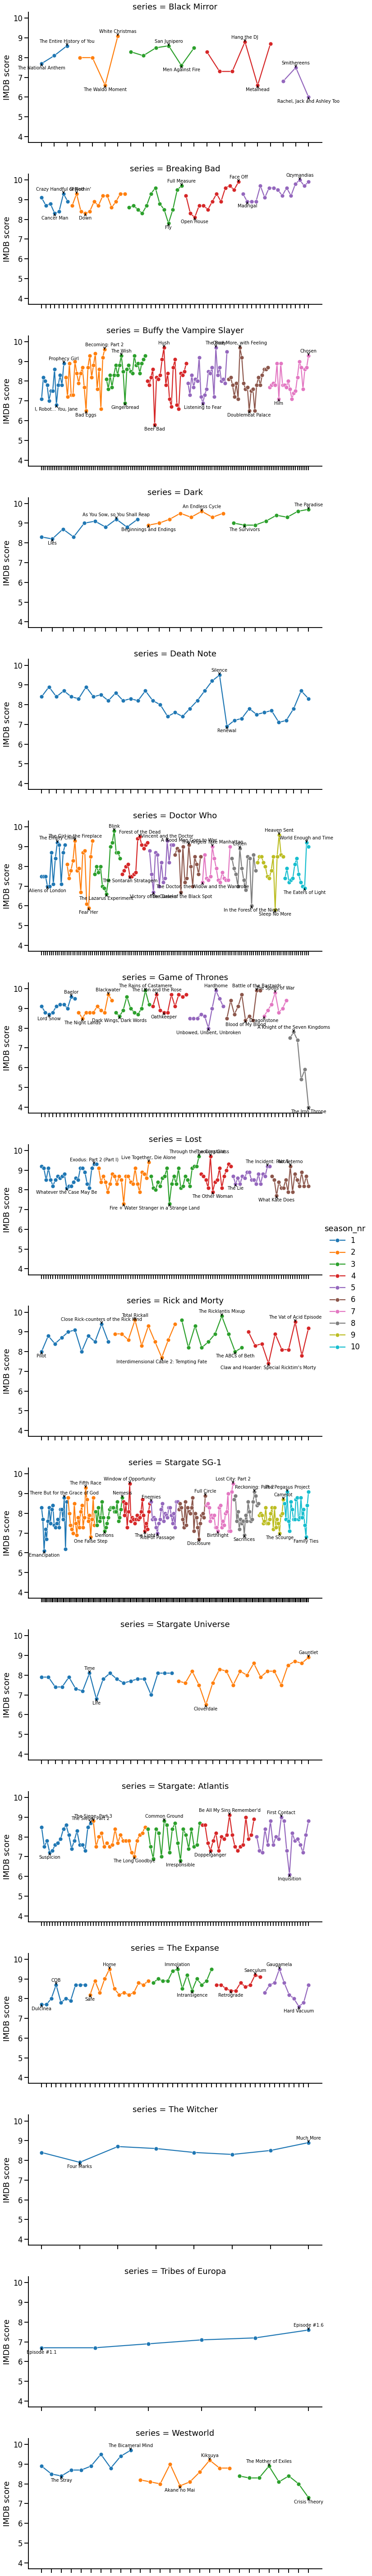

In [10]:
g = sns.FacetGrid(
    df.dropna(),
    row='series',
    hue='season_nr',
    sharex=False,
    sharey=True,
    aspect=2,
    height=5,
)

g.map_dataframe(sns.lineplot, x='idx', y='rating', marker='o', estimator=None)

g.set_xticklabels([])
g.set_ylabels('IMDB score')

g.add_legend()

# annotate episodes
for (i, j, k), data in g.facet_data():
    # row, col, hue
    ax = g.facet_axis(i, j)

    if not data.empty:
        annotate_episode(data.loc[data['rating'].idxmax()], ax, 1)
        annotate_episode(data.loc[data['rating'].idxmin()], ax, -1)